In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from tqdm import tqdm
from copy import deepcopy
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

### Decision tree

### 1 The CART algorithm

1. Start at the root node, with all training data in a single group. 

2. For **each possible value** and for **each feature**, calculate a splitting metric such as the Gini impurity. 

3. Perform a split of the data into two child nodes based on the split that has the highest impurity.

4. Continue until the data cannot be split any further, or a stopping condition is met.

For the splitting metric, we use the Gini impurity 

$$ G= \sum_i^C p(i)(1-p(i)) $$

where there are $C$ classes, and $p(i)$ is the probability of picking a data point with class $i$

### 2 Decision tree from scratch

Now we are going to define some useful helper functions:

* `is_numeric` helps us to handle mixed datasets. If the column is numeric, we split by thresholding (e.g. $X$ greater than the threshold value is assigned to the right node, and vice versa). If the column is categorical, we split by equality (e.g. only `X=='elephant'` goes to the right node, all other values to the left node)
* `split` performs a split of a given array based on the given threshold
* `calculate_best_split` goes through the entire training set, calculating the Gini index for every unique value in every column to find the single data split that yields the greatest information gain
* `grow_tree` is a simple recursive function that carries out the decision tree logic
    * It creates a hierarchy of `Node`s, each of which has a left and a right node
    * Each `Node` has information about its label (which is largely meaningless until the final node is reached), the column to split on and the threshold for splitting
    * Both the `Node` and the Gini index are recursively calculated until some stopping criterion is reached. In this case I don't constrain the tree depth and so splitting only stops when there are no more data rows to split. 

In [2]:
def is_numeric(obj):
    '''Helper function to check if an object is numeric.'''
    attrs = ['__add__', '__sub__', '__mul__', '__truediv__', '__pow__']
    return all(hasattr(obj, attr) for attr in attrs)

def split(x, threshold):
    '''Splits an array based on threshold.'''    
    isNumeric = is_numeric(x)
    if isNumeric:
        idx = x > threshold
    else:
        idx = x == threshold
    return(idx)

In [3]:
def calculate_best_split(X, y):

    '''
    Given a dataset and its target values, finds the best possible split.
    '''

    if len(y) <= 1:
        return None, None

    best_gini, best_column, best_val = np.inf, np.inf, np.inf

    for i in range(X.shape[1]): # 1. For each feature (column)...
        unique_values = np.unique(X[:,i])

        for val in unique_values: # 2. and for each unique value in the feature...

            query_right = y[np.argwhere(split(X[:,i], val)).reshape(1,-1)[0]]        
            query_left = y[np.argwhere(~split(X[:,i], val)).reshape(1,-1)[0]]
            gini_right = 1 - np.sum([(query_right.tolist().count(i)/len(query_right))**2 for i in np.unique(query_right)])
            gini_left = 1 - np.sum([(query_left.tolist().count(i)/len(query_left))**2 for i in np.unique(query_left)])        

            # 3. Calculate the CART cost function from weighted Gini values arising from the split
            gini_index = len(query_left)/len(y) * gini_left + len(query_right)/len(y) * gini_right

            # 4. Record the best split
            if gini_index < best_gini:
                best_gini = gini_index
                best_column = i
                best_val = val

    return (best_column, best_val)




Now we can recursively split the dataset. To show how it works we will first do this manually.

In [4]:
def split_data(X, y, column, threshold):
    '''Takes best split parameters and splits the data according to it'''
    
    if is_numeric(threshold):
        left_idx = np.argwhere(X[:,column] <= threshold).reshape(1,-1)[0]
        right_idx = np.argwhere(X[:,column] > threshold).reshape(1,-1)[0]
        X_left = X[left_idx,:]
        X_right = X[right_idx,:]
        y_left = y[left_idx]
        y_right = y[right_idx]
    else:
        left_idx = np.argwhere(X[:,column] != threshold).reshape(1,-1)[0]
        right_idx = np.argwhere(X[:,column] == threshold).reshape(1,-1)[0]
        X_left = X[left_idx,:]
        X_right = X[right_idx,:]
        y_left = y[left_idx]
        y_right = y[right_idx]

    return(X_left, X_right, y_left, y_right)
        

In [5]:
class Node:
    def __init__(self, label):
        self.label = label
        self.column = np.nan
        self.threshold = np.nan
        self.left = None
        self.right = None

def grow_tree(X,y, num_classes=2):
    samples_per_class = [np.sum(y==i) for i in range(num_classes)]
    designated_label = np.argmax(samples_per_class)
    node = Node(label=designated_label)
    node.column, node.threshold = calculate_best_split(X, y)
    if node.column is not None:        
        X_left, X_right, y_left, y_right = split_data(X,y, node.column, node.threshold)  
        if len(y_left) > 1 and len(y_right) > 1:
            node.left = grow_tree(X_left, y_left)
            node.right = grow_tree(X_right, y_right)
    return(node)

Now we test this function on the breast cancer dataset (which is split into train and test sets).

In [46]:
dataset = datasets.load_breast_cancer()
X = dataset.data
y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [47]:
node = grow_tree(X_train, y_train, num_classes=len(set(y_train)))

selected_idx = 29
input = X_test[selected_idx]

while node.right:
    if is_numeric(node.threshold):
        if input[node.column] > node.threshold:
            node = node.right
        else:
            node = node.left
    else:
        if input[node.column] == node.threshold:
            node = node.right
        else:
            node = node.left

print("Predicted", node.label, "Actual", y_test[selected_idx])

Predicted 1 Actual 1


### 3 Packaged version of the decision tree

This seems to work, but it would be helpful to put the classifier in a single reusable object that we can call training and inference functions on demand. The class here is written in a Scikit-learn-esque style

* A `predict` function takes in the training data and targets
* A `fit` function allows the fitted model to make predictions on unseen data, that is, the test dataset



In [39]:
class Node:
    def __init__(self, label):
        self.label = label
        self.column = np.nan
        self.threshold = np.nan
        self.left = None
        self.right = None

class DecisionTree:
    def __init__(self):
        pass

    def grow_tree(self, X, y, num_classes=3):
        samples_per_class = [np.sum(y==i) for i in range(num_classes)]
        designated_label = np.argmax(samples_per_class)
        node = Node(label=designated_label)
        node.column, node.threshold = DecisionTree.calculate_best_split(X, y)
        if node.column is not None:        
            X_left, X_right, y_left, y_right = DecisionTree.split_data(X,y, node.column, node.threshold)  
            if len(y_left) > 1 and len(y_right) > 1:
                node.left = self.grow_tree(X_left, y_left)
                node.right = self.grow_tree(X_right, y_right)
        return(node)

    @staticmethod
    def is_numeric(obj):
        '''Helper function to check if an object is numeric.'''
        attrs = ['__add__', '__sub__', '__mul__', '__truediv__', '__pow__']
        return all(hasattr(obj, attr) for attr in attrs)

    @staticmethod
    def split(x, threshold):
        '''Splits an array based on threshold.'''    
        isNumeric = DecisionTree.is_numeric(x)
        if isNumeric:
            idx = x > threshold
        else:
            idx = x == threshold
        return(idx)     

    @staticmethod
    def calculate_best_split(X, y):

        '''
        Given a dataset and its target values, finds the best possible split.
        '''

        if len(y) <= 1:
            return None, None

        best_gini, best_column, best_val = np.inf, np.inf, np.inf

        for i in range(X.shape[1]): # 1. For each feature (column)...
            unique_values = np.unique(X[:,i])

            for val in unique_values: # 2. and for each unique value in the feature...

                query_right = y[np.argwhere(split(X[:,i], val)).reshape(1,-1)[0]]        
                query_left = y[np.argwhere(~split(X[:,i], val)).reshape(1,-1)[0]]
                gini_right = 1 - np.sum([(query_right.tolist().count(i)/len(query_right))**2 for i in np.unique(query_right)])
                gini_left = 1 - np.sum([(query_left.tolist().count(i)/len(query_left))**2 for i in np.unique(query_left)])        

                # 3. Calculate the CART cost function from weighted Gini values arising from the split
                gini_index = len(query_left)/len(y) * gini_left + len(query_right)/len(y) * gini_right

                # 4. Record the best split
                if gini_index < best_gini:
                    best_gini = gini_index
                    best_column = i
                    best_val = val

        return (best_column, best_val)

    @staticmethod
    def split_data(X, y, column, threshold):
        '''Takes best split parameters and splits the data according to it'''
        
        if is_numeric(threshold):
            left_idx = np.argwhere(X[:,column] <= threshold).reshape(1,-1)[0]
            right_idx = np.argwhere(X[:,column] > threshold).reshape(1,-1)[0]
            X_left = X[left_idx,:]
            X_right = X[right_idx,:]
            y_left = y[left_idx]
            y_right = y[right_idx]
        else:
            left_idx = np.argwhere(X[:,column] != threshold).reshape(1,-1)[0]
            right_idx = np.argwhere(X[:,column] == threshold).reshape(1,-1)[0]
            X_left = X[left_idx,:]
            X_right = X[right_idx,:]
            y_left = y[left_idx]
            y_right = y[right_idx]

        return(X_left, X_right, y_left, y_right)

    def fit(self, X, y):
        number_of_classes = len(set(y))
        self.tree = self.grow_tree(X, y, number_of_classes)

    def predict(self, X_in):
        predictions = []
        for x in X_in:
            node = self.tree
            while node.right:
                if DecisionTree.is_numeric(node.threshold):
                    if x[node.column] > node.threshold:
                        node = node.right
                    else:
                        node = node.left
                else:
                    if x[node.column] == node.threshold:
                        node = node.right
                    else:
                        node = node.left
            predictions.append(node.label)
        return(predictions)

        

In [49]:
dataset = datasets.load_breast_cancer()
X = dataset.data
y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X,y)

dt = DecisionTree()
dt.fit(X_train, y_train)

In [50]:
y_preds = dt.predict(X_test)

<ipython-input-51-534f54708c99>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels);


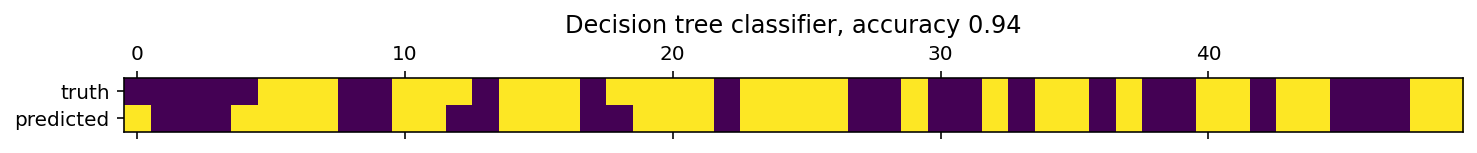

In [51]:
fig,ax = plt.subplots(figsize=(12,6))
ax.matshow([y_test[0:50], y_preds[0:50]])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = 'truth'
labels[2] = 'predicted'
ax.set_yticklabels(labels);
ax.set_title('Decision tree classifier, accuracy %.2f' % (accuracy_score(y_preds, y_test)));

The performance is quite decent - approximately 90% accuracy. 